In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('DataPreprocessing/processed_data.csv')

In [3]:
# Define the ordinal mapping for 'c_charge_degree'
ordinal_mapping = {
    "(F3)": 6,  # Highest severity
    "(F2)": 5,
    "(F1)": 4,
    "(M3)": 3,
    "(M2)": 2,
    "(M1)": 1   # Lowest severity
}

# Apply the ordinal mapping to the 'c_charge_degree' column
df['c_charge_degree'] = df['c_charge_degree'].astype(str).map(ordinal_mapping)

In [4]:
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,priors_count.1,event
0,1,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,...,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,14/08/2013,0,0
1,2,michael ryan,michael,ryan,31/12/2014,Male,06/02/1985,31,25 - 45,Caucasian,...,Risk of Recidivism,5,Medium,31/12/2014,Risk of Violence,2,Low,31/12/2014,0,0
2,3,kevon dixon,kevon,dixon,27/01/2013,Male,22/01/1982,34,25 - 45,African-American,...,Risk of Recidivism,3,Low,27/01/2013,Risk of Violence,1,Low,27/01/2013,0,1
3,4,ed philo,ed,philo,14/04/2013,Male,14/05/1991,24,Less than 25,African-American,...,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,14/04/2013,4,0
4,5,marcu brown,marcu,brown,13/01/2013,Male,21/01/1993,23,Less than 25,African-American,...,Risk of Recidivism,8,High,13/01/2013,Risk of Violence,6,Medium,13/01/2013,1,0


In [5]:
df['race'] = pd.Categorical(df['race'])
df['race_code'] = df['race'].cat.codes

In [6]:
# Split the data into features and target variable
X = df[["age", "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", "race_code"]]  # Features including race
y = df['is_recid']

In [7]:
X.head()

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,race_code
0,69,0,0,0,0,5
1,31,0,0,0,0,2
2,34,0,0,0,0,0
3,24,0,0,1,4,0
4,23,0,1,0,1,0


In [8]:
# Initialize the imputer to replace NaNs with the mean of the column
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Fit the imputer and transform the dataset
X_imputed = imputer.fit_transform(X)

# imputed_columns = X.columns

# Convert imputed data back to DataFrame
X = pd.DataFrame(X_imputed)

In [9]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
test_indices = X_test.index

In [11]:
# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
# Initialize the Multilayer Neural Network classifier
mlp_model = MLPClassifier(random_state=42)

# Train the model
mlp_model.fit(X_train, y_train)

# Predict using the trained model
y_pred = mlp_model.predict(X_test)


In [13]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Output the evaluation results
print("Multilayer Neural Network Model")
print(f"Accuracy: {accuracy:.2f}")
print(report)

Multilayer Neural Network Model
Accuracy: 0.73
              precision    recall  f1-score   support

           0       0.75      0.89      0.81      1507
           1       0.65      0.40      0.49       753

    accuracy                           0.73      2260
   macro avg       0.70      0.65      0.65      2260
weighted avg       0.71      0.73      0.71      2260



In [14]:
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

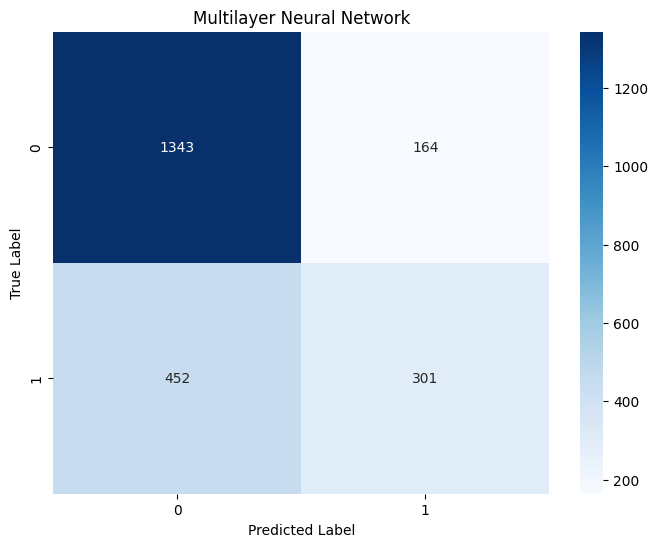

In [15]:
plot_confusion_matrix(cm, 'Multilayer Neural Network')

In [16]:
# Add the predictions to the original dataframe
df.loc[test_indices, 'is_recid_pred'] = y_pred
race_metrics = pd.DataFrame(columns=['Race', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# # Visualize the results segregated by race
# for race in df['race'].cat.categories:
#     race_df = df[(df['race'] == race) & (df.index.isin(test_indices))]
#     sns.countplot(x='is_recid_pred', data=race_df)
#     plt.title(f'Predictions for {race}')
#     plt.xlabel('Predicted Recidivism')
#     plt.ylabel('Count')
#     plt.show()

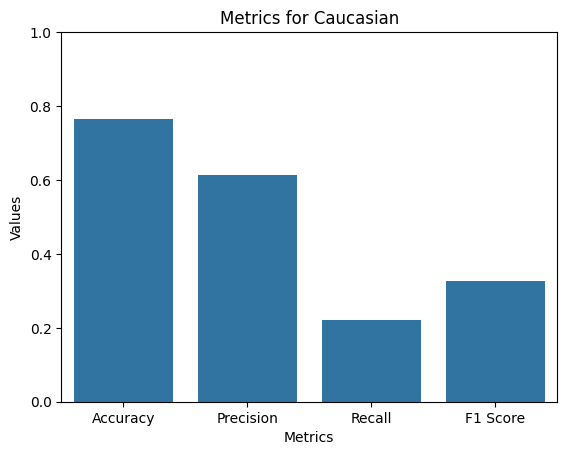

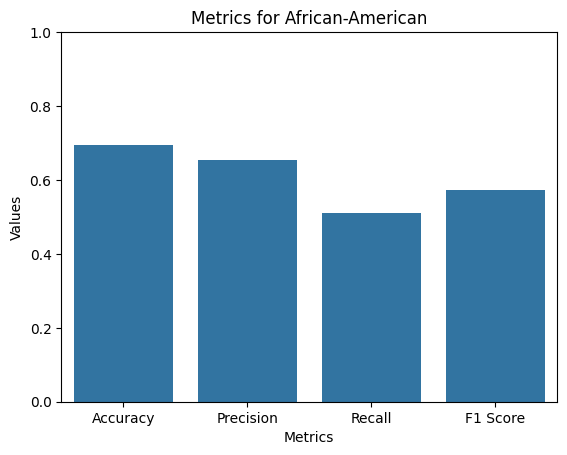

In [17]:
races = ['Caucasian', 'African-American']
for race in races:
    race_df = df[(df['race'] == race) & (df.index.isin(test_indices))]
    y_test_race = race_df['is_recid']
    y_pred_race = race_df['is_recid_pred']
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_race, y_pred_race)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_race, y_pred_race, average='binary')
    
    # Append the metrics to the DataFrame
    race_metrics = race_metrics.append({'Race': race, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}, ignore_index=True)
    
    # Plot the metrics
    metrics_df = pd.DataFrame({'Metrics': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                               'Values': [accuracy, precision, recall, f1]})
    sns.barplot(x='Metrics', y='Values', data=metrics_df)
    plt.title(f'Metrics for {race}')
    plt.ylim(0, 1)  # Assuming metrics are between 0 and 1
    plt.show()

In [71]:
race_metrics

,Race,Accuracy,Precision,Recall,F1 Score
0,Caucasian,0.756596,0.525862,0.208904,0.299020
1,African-American,0.706460,0.651629,0.541667,0.591581


In [26]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from imblearn.over_sampling import SMOTE

In [27]:
print('race' in df.columns)

True


In [28]:
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,priors_count.1,event,race_code,is_recid_pred
0,1,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,...,Low,14/08/2013,Risk of Violence,1,Low,14/08/2013,0,0,5,0.0
1,2,michael ryan,michael,ryan,31/12/2014,Male,06/02/1985,31,25 - 45,Caucasian,...,Medium,31/12/2014,Risk of Violence,2,Low,31/12/2014,0,0,2,NaN
2,3,kevon dixon,kevon,dixon,27/01/2013,Male,22/01/1982,34,25 - 45,African-American,...,Low,27/01/2013,Risk of Violence,1,Low,27/01/2013,0,1,0,NaN
3,4,ed philo,ed,philo,14/04/2013,Male,14/05/1991,24,Less than 25,African-American,...,Low,14/04/2013,Risk of Violence,3,Low,14/04/2013,4,0,0,1.0
4,5,marcu brown,marcu,brown,13/01/2013,Male,21/01/1993,23,Less than 25,African-American,...,High,13/01/2013,Risk of Violence,6,Medium,13/01/2013,1,0,0,NaN


In [29]:
# df = df[["age", "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count"]]
X = df[["age", "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", "is_recid"]]  # Features including race
y = df['race']

In [30]:
# # Separate the features and the race column
# race = X['race']
df.dropna()
df.head()
# X = X.drop('race', axis=1)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,priors_count.1,event,race_code,is_recid_pred
0,1,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,...,Low,14/08/2013,Risk of Violence,1,Low,14/08/2013,0,0,5,0.0
1,2,michael ryan,michael,ryan,31/12/2014,Male,06/02/1985,31,25 - 45,Caucasian,...,Medium,31/12/2014,Risk of Violence,2,Low,31/12/2014,0,0,2,NaN
2,3,kevon dixon,kevon,dixon,27/01/2013,Male,22/01/1982,34,25 - 45,African-American,...,Low,27/01/2013,Risk of Violence,1,Low,27/01/2013,0,1,0,NaN
3,4,ed philo,ed,philo,14/04/2013,Male,14/05/1991,24,Less than 25,African-American,...,Low,14/04/2013,Risk of Violence,3,Low,14/04/2013,4,0,0,1.0
4,5,marcu brown,marcu,brown,13/01/2013,Male,21/01/1993,23,Less than 25,African-American,...,High,13/01/2013,Risk of Violence,6,Medium,13/01/2013,1,0,0,NaN


In [32]:
X.head()

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,is_recid
0,69,0,0,0,0,0
1,31,0,0,0,0,0
2,34,0,0,0,0,1
3,24,0,0,1,4,1
4,23,0,1,0,1,0


In [33]:
# Define the sampling strategy for undersampling and oversampling
sampling_strategy = {'African-American': 6000, 'Caucasian': 6000}  # Example numbers
print(df['race'].value_counts())

African-American    5641
Caucasian           3902
Hispanic            1044
Other                617
Asian                 58
Native American       38
Name: race, dtype: int64


In [35]:
# Apply RandomUnderSampler to undersample the majority class
rus = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [36]:
X_resampled.head()

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,is_recid
0,69,0,0,0,0,0
1,31,0,0,0,0,0
2,34,0,0,0,0,1
3,24,0,0,1,4,1
4,23,0,1,0,1,0


In [37]:
y_resampled.head()

0               Other
1           Caucasian
2    African-American
3    African-American
4    African-American
Name: race, dtype: category
Categories (6, object): ['African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other']

In [39]:
X_resampled['race'] = y_resampled

In [40]:
X_resampled

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,is_recid,race
0,69,0,0,0,0,0,Other
1,31,0,0,0,0,0,Caucasian
2,34,0,0,0,0,1,African-American
3,24,0,0,1,4,1,African-American
4,23,0,1,0,1,0,African-American
...,...,...,...,...,...,...,...
13752,39,0,0,0,1,0,Caucasian
13753,23,0,0,0,1,0,Caucasian
13754,49,0,0,0,0,0,Caucasian
13755,56,0,0,0,0,0,Caucasian


In [72]:
X_resampled['race'] = pd.Categorical(X_resampled['race'])
X_resampled['race_code'] = X_resampled['race'].cat.codes

In [73]:
X_balanced = X_resampled[["age", "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", "race_code"]]
y_balanced = X_resampled["is_recid"]

In [74]:
# Split the data into training and test sets
X_train, X_test_new, y_train, y_test_new = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [75]:
test_indices = X_test.index

In [76]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [77]:
# Initialize the MLP classifier
mlp = MLPClassifier(random_state=42)

# Train the MLP classifier on the balanced dataset
mlp.fit(X_train_scaled, y_train)

# Validate the model on the original dataset
y_pred = mlp_model.predict(X_test_scaled)

In [78]:
# Calculate metrics on the original dataset
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

# Output the evaluation results
print("Evaluation on Original Data")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Evaluation on Original Data
Accuracy: 0.74
Precision: 0.62
Recall: 0.40
F1 Score: 0.49


In [79]:
r_df = X_resampled
# Add the predictions to the original dataframe
r_df.loc[test_indices, 'is_recid_pred'] = y_pred
race_metrics = pd.DataFrame(columns=['Race', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

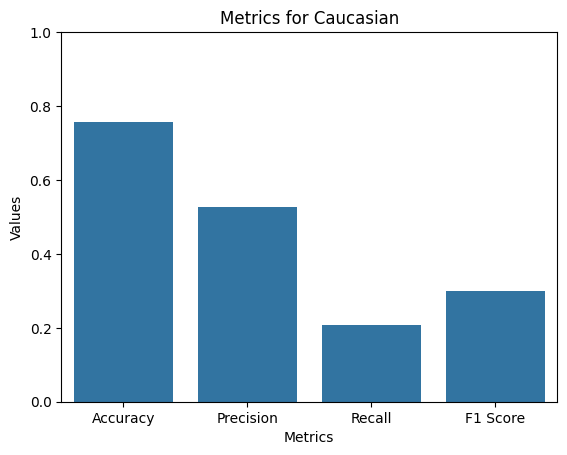

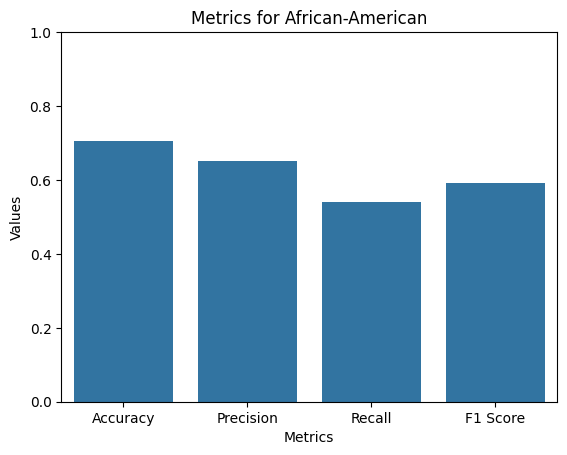

In [80]:
races = ['Caucasian', 'African-American']
for race in races:
    race_df = r_df[(r_df['race'] == race) & (r_df.index.isin(test_indices))]
    y_test_race = race_df['is_recid']
    y_pred_race = race_df['is_recid_pred']
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_race, y_pred_race)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_race, y_pred_race, average='binary')
    
    # Append the metrics to the DataFrame
    race_metrics = race_metrics.append({'Race': race, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}, ignore_index=True)
    
    # Plot the metrics
    metrics_df = pd.DataFrame({'Metrics': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                               'Values': [accuracy, precision, recall, f1]})
    sns.barplot(x='Metrics', y='Values', data=metrics_df)
    plt.title(f'Metrics for {race}')
    plt.ylim(0, 1)  # Assuming metrics are between 0 and 1
    plt.show()

In [70]:
race_metrics

,Race,Accuracy,Precision,Recall,F1 Score
0,Caucasian,0.756596,0.525862,0.208904,0.299020
1,African-American,0.706460,0.651629,0.541667,0.591581
